In [15]:
%store -r  X
%store -r  y

%store -r  x_train
%store -r  x_test

%store -r  y_train
%store  -r y_test

%store -r col_trans

%store -r scoring

In [16]:

from sklearn.metrics import classification_report, confusion_matrix


def eval_matric (model, x_train, y_train,x_test, y_test):
    y_train_pred = model.predict(x_train)
    y_pred = model.predict(x_test)

    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))


## XGBoost Model

In [17]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


ops_xgb = [("Oridnalencoder", col_trans),
           ("xgb_model", XGBClassifier(random_state = 101))
           ]


pipe_xgb_model = Pipeline(steps=ops_xgb)


y_train_xgb = y_train.map({"Black": 0, "Hispanic": 1, "White": 2})
y_test_xgb = y_test.map({"Black": 0, "Hispanic": 1, "White": 2})
# If the target is not numeric in xgb 1.6 and higher versions, it returns an error.
# That's why we do the conversion manually.

pipe_xgb_model.fit(x_train,y_train_xgb)


c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Oridnalencoder',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Gender', 'WritingPreference'], dtype='object'))])),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [18]:
eval_matric(pipe_xgb_model, x_train,y_train_xgb,x_test, y_test_xgb)




Test_Set
[[214  13  33]
 [  8  32  96]
 [  9  13 736]]
              precision    recall  f1-score   support

           0       0.93      0.82      0.87       260
           1       0.55      0.24      0.33       136
           2       0.85      0.97      0.91       758

    accuracy                           0.85      1154
   macro avg       0.78      0.68      0.70      1154
weighted avg       0.83      0.85      0.83      1154


Train_Set
[[1038    0    0]
 [   0  543    0]
 [   0    0 3034]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1038
           1       1.00      1.00      1.00       543
           2       1.00      1.00      1.00      3034

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [19]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight="balanced", y=y_train_xgb
)
classes_weights

# XGboost algorithm has no class_weight hyperparameter for multiclass.
# We can use the sample_weight hyperparameter within the fit function.

array([0.50703142, 0.50703142, 0.50703142, ..., 0.50703142, 0.50703142,
       0.50703142])

In [20]:
import pandas as pd


my_dict = {"weights": classes_weights, "label": y_train_xgb}

comp = pd.DataFrame(my_dict)

comp.head()

,weights,label
5165,0.507031,2
5393,0.507031,2
5659,0.507031,2
3628,0.507031,2
2914,0.507031,2


In [21]:
comp.groupby("label").value_counts()


label  weights 
0      1.482017    1038
1      2.833026     543
2      0.507031    3034
Name: count, dtype: int64

In [23]:
pipe_xgb_model.fit(x_train, y_train_xgb, xgb_model__sample_weight=classes_weights)
# weight parameter in XGBoost is per instance not per class. Therefore,
# we need to assign the weight of each class to its instances,
# which is the same thing.

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('Oridnalencoder',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Gender', 'WritingPreference'], dtype='object'))])),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [24]:
eval_matric(pipe_xgb_model, x_train, y_train_xgb, x_test, y_test_xgb)

Test_Set
[[222  14  24]
 [  9  49  78]
 [ 15  36 707]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       260
           1       0.49      0.36      0.42       136
           2       0.87      0.93      0.90       758

    accuracy                           0.85      1154
   macro avg       0.76      0.72      0.73      1154
weighted avg       0.84      0.85      0.84      1154


Train_Set
[[1038    0    0]
 [   0  543    0]
 [   0    0 3034]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1038
           1       1.00      1.00      1.00       543
           2       1.00      1.00      1.00      3034

    accuracy                           1.00      4615
   macro avg       1.00      1.00      1.00      4615
weighted avg       1.00      1.00      1.00      4615



In [25]:
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score

# Since xgb does not accept non-encoded targets, we arrange the scoring_xgb
# according to the 1 numeric class corresponding to hispanics.

scoring_xgb = {
    "precision_Hispanic": make_scorer(precision_score, average=None, labels=[1]),
    "recall_Hispanic": make_scorer(recall_score, average=None, labels=[1]),
    "f1_Hispanic": make_scorer(f1_score, average=None, labels=[1]),
}


In [27]:
from sklearn.model_selection import cross_validate


operations = [
    ("ordinalEncoder", col_trans),
    ("xgb_model", XGBClassifier(random_state=101))
]


model = Pipeline(steps=operations)


scores = cross_validate(model, 
                        x_train,
                        y_train_xgb,
                        scoring=scoring_xgb,
                        n_jobs=-1,
                        return_train_score=True,
                        fit_params={"xgb_model__sample_weight":classes_weights})

df_scores = pd.DataFrame(scores, index=range(1, 6))
df_scores.mean()[2:]

test_precision_Hispanic     0.523398
train_precision_Hispanic    1.000000
test_recall_Hispanic        0.279969
train_recall_Hispanic       1.000000
test_f1_Hispanic            0.364119
train_f1_Hispanic           1.000000
dtype: float64

In [28]:
## GridSearchCV

param_grid = {
    "xgb_model__n_estimators": [20, 40],
    "xgb_model__max_depth": [1, 2],
    "xgb_model__learning_rate": [0.03, 0.05],
    "xgb_model__subsample": [0.8, 1],
    "xgb_model__colsample_bytree": [0.8, 1],
}

In [30]:
from sklearn.model_selection import GridSearchCV


operations_xgb = [
    ("OrdinalEncoder", col_trans),
    ("xgb_model", XGBClassifier(random_state=101)),
]

model = Pipeline(steps=operations_xgb)

xgb_grid_model = GridSearchCV(
    model,
    param_grid,
    scoring=make_scorer(recall_score, average=None, labels=[1]),
    cv=5,
    n_jobs=-1,
    return_train_score=True,
)

In [31]:
xgb_grid_model.fit(x_train, y_train_xgb, xgb_model__sample_weight=classes_weights)

c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('OrdinalEncoder',
                                        ColumnTransformer(remainder=MinMaxScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         Index(['Gender', 'WritingPreference'], dtype='object'))])),
                                       ('xgb_model',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_b...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=101, ...))]),
             n_jobs=-1,
             param_grid={'xgb_model__colsample_bytree': [0.8, 1],
                         'xgb_model__learning_rate': [0.03, 0.05],
                         'xgb_model__max_depth': [1, 2],
                         'xgb_model__n_estimators': [20, 40],
                         'xgb_model__subsample': [0.8, 1]},
             return_train_score=True,
             scoring=make_scorer(recall_score, average=None, labels=[1]))

In [32]:
xgb_grid_model.best_estimator_

Pipeline(steps=[('OrdinalEncoder',
                 ColumnTransformer(remainder=MinMaxScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  Index(['Gender', 'WritingPreference'], dtype='object'))])),
                ('xgb_model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=40,
                               n_jobs=None, num_parallel_tree=None,
                               objective='multi:softprob', predictor=None, ...))])

In [33]:
xgb_grid_model.best_params_

{'xgb_model__colsample_bytree': 0.8,
 'xgb_model__learning_rate': 0.05,
 'xgb_model__max_depth': 1,
 'xgb_model__n_estimators': 40,
 'xgb_model__subsample': 0.8}

In [34]:
pd.DataFrame(xgb_grid_model.cv_results_).loc[
    xgb_grid_model.best_index_, ["mean_test_score", "mean_train_score"]
]

mean_test_score     0.563592
mean_train_score    0.587463
Name: 10, dtype: object

In [35]:
xgb_grid_model.best_score_

0.5635915732246006

In [36]:
eval_matric(xgb_grid_model, x_train, y_train_xgb, x_test, y_test_xgb)

Test_Set
[[167  56  37]
 [ 27  71  38]
 [ 93 266 399]]
              precision    recall  f1-score   support

           0       0.58      0.64      0.61       260
           1       0.18      0.52      0.27       136
           2       0.84      0.53      0.65       758

    accuracy                           0.55      1154
   macro avg       0.53      0.56      0.51      1154
weighted avg       0.71      0.55      0.59      1154


Train_Set
[[ 666  198  174]
 [  83  322  138]
 [ 325  967 1742]]
              precision    recall  f1-score   support

           0       0.62      0.64      0.63      1038
           1       0.22      0.59      0.32       543
           2       0.85      0.57      0.68      3034

    accuracy                           0.59      4615
   macro avg       0.56      0.60      0.54      4615
weighted avg       0.72      0.59      0.63      4615



c:\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


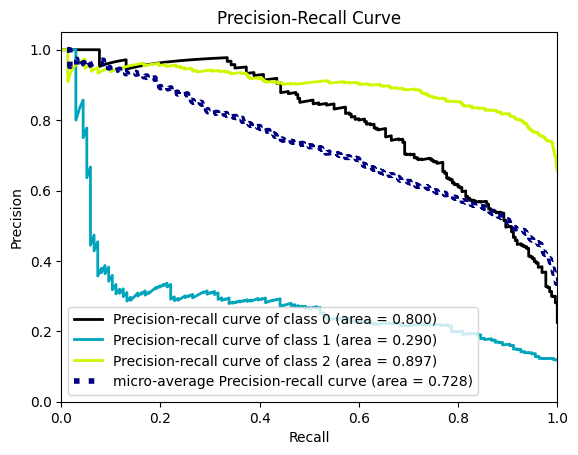

In [40]:
from matplotlib import pyplot as plt
from scikitplot.metrics import plot_roc, precision_recall_curve ,plot_precision_recall
operations_xgb = [
    ("OrdinalEncoder", col_trans),
    (
        "xgb_model",
        XGBClassifier(
            colsample_bytree=0.8,
            learning_rate=0.05,
            max_depth=2,
            n_estimators=40,
            subsample=1,
            random_state=101,
        ),
    ),
]

model = Pipeline(steps=operations_xgb)

model.fit(x_train, y_train_xgb, xgb_model__sample_weight=classes_weights)

y_pred_proba = model.predict_proba(x_test)

plot_precision_recall(y_test_xgb, y_pred_proba)
plt.show()

In [41]:
y_test_xgb_dummies = pd.get_dummies(y_test_xgb).values

In [44]:
from sklearn.metrics import average_precision_score

average_precision_score(y_test_xgb_dummies[:, 1], y_pred_proba[:, 1])

0.28969524484938647

In [45]:
y_pred = xgb_grid_model.predict(x_test)

xgb_AP = average_precision_score(y_test_xgb_dummies[:, 1], y_pred_proba[:, 1])
xgb_f1 = f1_score(y_test_xgb, y_pred, average=None, labels=[1])
xgb_recall = recall_score(y_test_xgb, y_pred, average=None, labels=[1])

In [46]:
%store xgb_recall 
%store xgb_AP
%store xgb_f1

Stored 'xgb_recall' (ndarray)
Stored 'xgb_AP' (float64)
Stored 'xgb_f1' (ndarray)
